In [ ]:
###Instaleren van Levenshtein module als dit nog niet gedaan is###

#pip install python-Levenshtein

In [86]:
## import libraries
%load_ext autoreload
%autoreload 2
import utilities as util
import os
import reedsolo
import random
import time
import matplotlib.pyplot as plt
import math
import numpy as np
import hashlib
import Levenshtein as lev

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
## set variables
# path to file to be encoded
path = os.path.relpath("C:\\Users\\justi\\Documents\\DBLCompBioGroup12\\Data\\Lorem ipsum.txt")
# percentage extra segments created (so if extra = 1.07, a file of 10000 segments gets turned into 10700 droplets)
extra = 1.1
# maximum allowed homopolymer length
max_homopolymer = 3
# number of error correcting code bytes added
ecc_bytes = 4
# filename of encoded droplet DNA strands
DNA_filename = "DNA_strands.txt"
# filename of results from simulation
collapsed_filename = "sequenced.txt"
# Whether or not to correct the droplets using RS
correct = True

In [108]:
def Encode(file_path, extra = 1.05, max_homopolymer = 3,ecc_bytes=4) -> list:
    """ Read and encode a file using the luby transform, returning a list of DNA sequences
    INPUT:
    file_path: path to the file to be encoded
    seed:  seed for the randomization of data
    extra: amount of extra droplets compared to data (default 5%, so 1.05)
    max_homopolymer: maximum length of homopolymer sequences allowed (default 3)
    OUTPUT:
    droplets: list of DNA sequences
    """
    # first read file
    data = util.OpenFile(file_path)
    # make bytearray from data
    data = bytearray(data)
    # determine how many segments the data will consist of and use it as a seed for randomization
    data = util.Bytearray2Binary(data)
    seed = math.ceil(len(data)/256)
    data = util.Binary2Bytearray(data)
    # randomize the data 
    data = util.RandomizeMessage(data, seed)
    # data needs to be converted to string for segmentation
    data = util.Bytearray2Binary(data)
    # add padding and segment
    data = util.Segment(data)
    # now the luby transform needs to be applied
    

    total_segments = len(data)
    print(total_segments)
    distribution_size = total_segments 
    # first convert segments to bytearrays
    data_bytearray = [util.Binary2Bytearray(segment) for segment in data]
    
    # create a Pseudo random number generator 
    prng = random.Random()
    seeds_lfsr = util.LFSR() #starting an lfsr with a certain state and a polynomial for 32bits.
    nr_droplets_probablities = util.RobustSoliton(distribution_size, 0.001, 0.025)
    droplets = []
    droplets_required = int(extra*total_segments)
    while len(droplets) < droplets_required:
        # generate a seed for droplet making
        seed = next(seeds_lfsr)
        # create droplet
        current_drop = util.MakeDroplet(data_bytearray, seed, prng, nr_droplets_probablities, ecc_bytes)
        # convert drop to string and then DNA
        current_drop = util.Binary2DNA(util.Bytearray2Binary(current_drop))
        # check biochemical requirements and append to list of droplets if ok
        if util.CheckBiochemicalRequirements(current_drop, max_homopolymer):
            droplets.append(current_drop)
    
    ##make metadata-strands
    metastrand = util.CreateMetaStrand(total_segments,ecc_bytes)
    
    for x in range(3): # now 3 for adding it in 3 times
        droplets.append(metastrand)
    
    return droplets

In [ ]:
encoded = Encode(path, extra, max_homopolymer,ecc_bytes)

2652


In [ ]:
f = open(DNA_filename, "w")
for i in encoded:
    f.write(i + "\n")
f.close()


In [97]:
len(encoded)

3981

In [84]:
len(encoded[390])

152

# DNA SYNTHESIS, STORAGE AND SEQUENCING

Code from Bas

In [98]:
def sim_seq_simple(sequences, dropout = 0.01, insert_rate = 0.00042, del_rate = 0.00188, sub_rate = 0.00407):
    # Takes sequences as a list of unique DNA sequences and simulates: synthesis, PCR and NGS
    # Dropout is the dropout rate (i.e. the number of sequences that are not recovered)
    # For baselevel errors we have insert_rate for insertions, del_rate for deletions and sub_rate for substitutions.
    # Default values for base errors are taken from https://www.nature.com/articles/nbt.4079
    s = sequences.copy()
    random.shuffle(s)
    for _ in range(0, int(dropout*len(s))):
        s.pop()
    
    for i in range(len(s)):
        seq_l = list(s[i])
        mod = 0 # Inserting messes with indexing so we skip over inserted bases using this counter
        for base_i in range(len(seq_l)):
            mutate_rand = random.random()
            if mutate_rand < insert_rate:
                # Insert random nucleotide after this base
                seq_l.insert(base_i+mod, random.choice(['A','C', 'T', 'G']))
                mod+=1
            elif mutate_rand > insert_rate and mutate_rand < (del_rate+insert_rate):
                # Delete this nucleotide (later)
                seq_l[base_i+mod] = '_'
            elif mutate_rand > (insert_rate+del_rate) and mutate_rand < (del_rate+insert_rate+sub_rate):
                # Substitute base
                seq_l[base_i+mod] = random.choice(['A', 'C', 'T', 'G'])
        if '_' in seq_l:
            for dels in range(seq_l.count('_')):
                seq_l.remove('_')
        s[i] = ''.join(seq_l)
    return s

In [99]:
with open("DNA_strands.txt", 'r') as f:
    dropletlist = [line.rstrip('\n') for line in f]
sequenced = sim_seq_simple(dropletlist, dropout = 0.001, insert_rate = 0.000042, del_rate = 0.000188, sub_rate = 0.000407)
with open("sequenced.txt", "w") as file:
    for i in sequenced:
        file.write(i + "\n")
    

# DECODING

In [100]:
with open(collapsed_filename, 'r') as f:
    dropletlist = [line.rstrip('\n') for line in f]

#total_segments = 18783 # moet geen variabele meer zijn
n=0
#check if all the droplets meet our requirements otherwise don't add them to the list of OKdroplets
metadata = []
OKdroplets = []
for strand in dropletlist:
    if util.CheckBiochemicalRequirements(strand):
        if util.CheckOligoLength (strand,length=144+ecc_bytes*4):
            if lev.distance("ACGTACGTACGTACGT", strand[:16]) <= 1:
                metadata.append(strand)
            else:
                OKdroplets.append(strand)
total_segments_list = [util.DecodeMetaStrand(metastrand,ecc_bytes) for metastrand in metadata]
total_segments = max(set(total_segments_list), key = total_segments_list.count)
print(total_segments)
simplified_droplets = []
corrected_droplets = []
rsc = reedsolo.RSCodec(ecc_bytes)
for strand in OKdroplets:
    binary_strand = util.DNA2Binary(strand)
    bytearray_strand = util.Binary2Bytearray(binary_strand)
#convert the list of strings to a bytearray 
    if rsc.check(bytearray_strand)[0]:
        droplet_seed = int(binary_strand[0:32], 2)
        segment_amount, segment_indices = util.RecoverSeed(droplet_seed, total_segments)
        payload = binary_strand[32:288]
        simplified_droplets.append((segment_indices, payload))
        n+=1
    elif correct:
        try:
            binary_strand = util.Bytearray2Binary(rsc.decode(bytearray_strand)[0])
            droplet_seed = int(binary_strand[0:32], 2)
            segment_amount, segment_indices = util.RecoverSeed(droplet_seed, total_segments)
            payload = binary_strand[32:288]
            corrected_droplets.append((segment_indices, payload))
        except Exception:
            pass
simplified_droplets += corrected_droplets
print(len(simplified_droplets)-n,len(simplified_droplets),len(OKdroplets),len(dropletlist))
#if the strand is correct according to reed-solomon, 
#make a list including the segment indices of the droplet and #their combined XOR

2652
233 3753 3754 3978


In [101]:
output_data = {}
input_data = simplified_droplets
newsolves = 1
while newsolves > 0:
    input_data, output_data, newsolves = util.Decode(input_data, output_data)


In [102]:
len(output_data)

2652

In [105]:
if len(output_data)==total_segments:
    solution = ''.join([output_data[x] for x in range(len(output_data))])
    solution = util.RemovePadding(solution)
    solution = util.RandomizeMessage(util.Binary2Bytearray(solution),len(output_data))
else:
    solution = bytearray(0)
    print('solution could not be reached, use another more robust method' + str(len(output_data)))

Run this code to write the recovered file, change the filename as you please. 

In [103]:
with open("Lorem ipsum recovered.txt", "wb") as file:
    file.write(solution)


In [106]:
solution

bytearray(b'Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. \r\n\r\nDuis autem vel eum iriure dolor in hendrerit in vulputate velit esse molestie consequat, vel

# Visualizing/Improving decoding

5 39


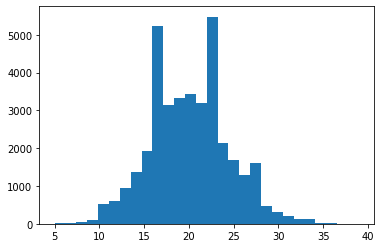

In [87]:
seg_dic = {x:0 for x in range(total_segments)}
for x in simplified_droplets:
    for ind in x[0]:
        seg_dic[ind] += 1

plt.hist(seg_dic.values(), bins=28)
print(min(seg_dic.values()),max(seg_dic.values()))

In [11]:
# nr_solves = []
# for i in range(len(simplified_droplets)):
#     output_data = {}
#     input_data = simplified_droplets[0:i]
#     newsolves = 1
#     while newsolves > 0:
#         input_data, output_data, newsolves = util.Decode(input_data, output_data)
#     nr_solves.append(len(output_data))

In [12]:
# x=range(len(simplified_droplets))
# plt.plot(x, nr_solves)

In [32]:
count=0
ind_unsolved = []
for x in input_data:
    for ind in x[0]:
        if ind not in ind_unsolved:
            ind_unsolved.append(ind)

ind_unsolved.sort()
    

In [33]:
ind_unsolved

[]